In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
from scipy.ndimage.morphology import binary_fill_holes

%matplotlib inline

In [2]:
img_shape = (64,64)

In [3]:
def pad_resize(img):
    top = int((224 - img.shape[0])/2)
    left = int((224 - img.shape[1])/2)
    bottom = 224 - img.shape[0] - top
    right = 224 - img.shape[1] - left
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)
    img = img/255.
    img = cv2.resize(img, img_shape) #KADD
    return img

def skeletonize(img):
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)
    img = cv2.bitwise_not(img)
#     element = cv2.getStructuringElement(cv2.MORPH_CROSS,(1,1))
#     done = 0
#     while( done < 1 ):
#         eroded = cv2.erode(img,element)
#         temp = cv2.dilate(eroded,element)
#         temp = cv2.subtract(img,temp)
#         skel = cv2.bitwise_or(skel,temp)
#         img = eroded.copy()

#         zeros = size - cv2.countNonZero(img)
#         if zeros==size:#cv2.countNonZero(img) * 1 >= 0:#
#             done += 1
#     img = skel
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 2)
    img = cv2.bitwise_not(erosion)
    return img

In [4]:
PATH = '../train_images_modified'
images = []
base_class = []
matra_class = []
dot_class = []
total_class = []
for filename in os.listdir(PATH):
    if filename.endswith(".png"):
        img = cv2.imread(os.path.join(PATH,filename),0)
        blur = cv2.GaussianBlur(img,(9,9),0)# KADD
        a,img = cv2.threshold(blur,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)#KEDIT
#         kernel = np.ones((5,5),np.uint8)
#         img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
#         plt.imshow(img, cmap='gray')
#         plt.show()
#        img = skeletonize(img)
        img = pad_resize(img)
        blur = cv2.GaussianBlur(img,(9,9),0)# KADD
        char_arr = filename[:-4].split('_')[3:]
        if(len(char_arr)>0):
            char_arr = [int(i) for i in char_arr]
            base = [i for i in char_arr if (i>=2308 and i<=2361) or (i==2384) or (i>=2392 and i<=2401) or (i>=2404 and i!=2416 and i!=2417)]  
            matra = [i for i in char_arr if i>=2362 and i<=2391 and i!=2364 and i!=2362]
            dot = [i for i in char_arr if i==2306 or i==2416 or i==2362 or i==2364]
            if(len(matra)>1 or len(dot)>1 or len(base)>1 or (len(matra)==0 and len(dot)==0 and len(char_arr)==2)):
                print(filename+" dropped!")
            else:
                images.append(img)
                base_class.append(base[0])
                if(len(matra)==1):
                    matra_class.append(matra[0])
                else:
                    matra_class.append(0)

                if len(dot)==1:
                    if dot[0] == 2364:
                        dot_class.append(2)
                    else:
                        dot_class.append(1)
                else:
                    dot_class.append(0)

                if len(images)%100==0:
                    print("{} Done".format(len(images)))
            

page7_16_10_2350_2417.png dropped!
100 Done
page3_6_0_2327_2417.png dropped!
page6_1_1_2340_2375_2379.png dropped!
200 Done
page7_3_0_2319_2366_2367.png dropped!
300 Done
page0_8_8_2330_2375_2379.png dropped!
400 Done
page6_10_6_2325_2366_2380.png dropped!
page0_9_15_2332_2375_2379.png dropped!
500 Done
600 Done
700 Done
page3_18_4_2332_2366_2379.png dropped!
page3_12_0_2357_2364_2416.png dropped!
800 Done
900 Done
page7_3_13_2319_2366_2367.png dropped!
1000 Done
1100 Done
1200 Done
1300 Done
1400 Done
page5_7_8_2325_2367_2388.png dropped!
1500 Done
page2_4_20_2346_2366_2390.png dropped!
1600 Done
1700 Done
1800 Done


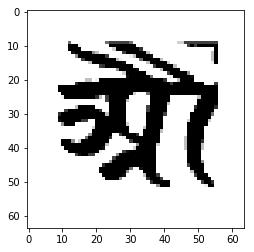

1883
1883


In [5]:
plt.imshow(images[10],"gray")
plt.show()
print(len(images))
print(len(dot_class))

In [6]:
len(set(base_class))
freq = {i:base_class.count(i) for i in base_class}
[i for i in freq.keys() if freq[i]==1]

[2392, 2353, 2384, 2415, 2310, 2414]

In [7]:
images = np.array(images)
print(images.shape)

(1883, 64, 64)


In [39]:
import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
le.fit(base_class)
y_labeled = le.transform(base_class)
y_train = np_utils.to_categorical(y_labeled)
print(y_train.shape)
#print(le)
#le.get_params()
#for i in range(len(topr)):
#    if base_class[i] == 2405:
#        print('{} {}'.format(topr[i], base_class[i]))

In [9]:
x_train = np.reshape(images,(-1,img_shape[0],img_shape[1],1))
print(x_train.shape)

(1883, 64, 64, 1)


In [10]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from keras.optimizers import Adam

base_model = Sequential()

base_model.add(Conv2D(16,(3,3),input_shape = (img_shape[0],img_shape[1],1),activation = 'relu'))
base_model.add(Conv2D(16,(3,3),activation = 'relu'))
base_model.add(MaxPooling2D())
base_model.add(Conv2D(32,(3,3),activation = 'relu'))
base_model.add(Conv2D(32,(3,3),activation = 'relu'))
base_model.add(MaxPooling2D())
base_model.add(Conv2D(64,(3,3),activation = 'relu'))
base_model.add(Conv2D(64,(3,3),activation = 'relu'))
base_model.add(MaxPooling2D())
base_model.add(MaxPooling2D())
base_model.add(Dropout(0.5))
base_model.add(Flatten())
base_model.add(Dense(256,activation = 'sigmoid'))
base_model.add(Dropout(0.25))
base_model.add(Dense(len(set(base_class)),activation = 'softmax'))

In [11]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
__________

In [12]:
import keras.backend as K

def f1_score(theta):
    def score(y_true, y_pred):

        y_thresh = K.cast(K.greater(y_pred,theta),K.floatx())

        true_pos =  K.sum(y_true * y_thresh)
        false_pos = K.sum(y_true * (1. - y_thresh))
        false_neg = K.sum((1. - y_true) * y_thresh)

        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        
        f1_score_val = 2 * (precision * recall) / (precision + recall)
        return f1_score_val
    return score

In [13]:
base_model.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# augmentation code here ...

In [14]:
base_model.fit(x_train,y_train,epochs=30,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 565 samples
Epoch 1/30
1318/1318 [==============================] - 13s 10ms/step - loss: 3.5233 - categorical_accuracy: 0.0774 - val_loss: 3.3618 - val_categorical_accuracy: 0.1168
Epoch 2/30
1318/1318 [==============================] - 13s 10ms/step - loss: 3.3961 - categorical_accuracy: 0.0979 - val_loss: 3.3650 - val_categorical_accuracy: 0.1168
Epoch 3/30
1318/1318 [==============================] - 13s 10ms/step - loss: 3.3769 - categorical_accuracy: 0.0895 - val_loss: 3.2976 - val_categorical_accuracy: 0.1186
Epoch 4/30
1318/1318 [==============================] - 13s 10ms/step - loss: 3.1800 - categorical_accuracy: 0.1601 - val_loss: 3.0184 - val_categorical_accuracy: 0.1823
Epoch 5/30
1318/1318 [==============================] - 14s 10ms/step - loss: 2.8914 - categorical_accuracy: 0.2436 - val_loss: 2.7400 - val_categorical_accuracy: 0.2743
Epoch 6/30
1318/1318 [==============================] - 16s 12ms/step - loss: 2.5368 - categorical_accu

In [15]:
new_adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
base_model.compile(optimizer=new_adam,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
base_model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 565 samples
Epoch 1/10
1318/1318 [==============================] - 20s 15ms/step - loss: 0.3479 - categorical_accuracy: 0.9059 - val_loss: 0.5887 - val_categorical_accuracy: 0.8407
Epoch 2/10
1318/1318 [==============================] - 14s 11ms/step - loss: 0.3177 - categorical_accuracy: 0.9143 - val_loss: 0.5848 - val_categorical_accuracy: 0.8478
Epoch 3/10
1318/1318 [==============================] - 16s 12ms/step - loss: 0.2932 - categorical_accuracy: 0.9165 - val_loss: 0.5929 - val_categorical_accuracy: 0.8372
Epoch 4/10
1318/1318 [==============================] - 18s 13ms/step - loss: 0.3073 - categorical_accuracy: 0.9234 - val_loss: 0.5902 - val_categorical_accuracy: 0.8389
Epoch 5/10
1318/1318 [==============================] - 15s 11ms/step - loss: 0.2903 - categorical_accuracy: 0.9294 - val_loss: 0.5872 - val_categorical_accuracy: 0.8425
Epoch 6/10
1318/1318 [==============================] - 17s 13ms/step - loss: 0.2862 - categorical_accu

In [16]:
new_adam = keras.optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
base_model.compile(optimizer=new_adam,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
base_model.fit(x_train,y_train,epochs=30,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 565 samples
Epoch 1/30
1318/1318 [==============================] - 17s 13ms/step - loss: 0.2793 - categorical_accuracy: 0.9219 - val_loss: 0.5969 - val_categorical_accuracy: 0.8407
Epoch 2/30
1318/1318 [==============================] - 17s 13ms/step - loss: 0.2636 - categorical_accuracy: 0.9264 - val_loss: 0.5898 - val_categorical_accuracy: 0.8442
Epoch 3/30
1318/1318 [==============================] - 15s 11ms/step - loss: 0.2675 - categorical_accuracy: 0.9302 - val_loss: 0.5908 - val_categorical_accuracy: 0.8389
Epoch 4/30
1318/1318 [==============================] - 15s 11ms/step - loss: 0.2585 - categorical_accuracy: 0.9401 - val_loss: 0.5933 - val_categorical_accuracy: 0.8442
Epoch 5/30
1318/1318 [==============================] - 14s 11ms/step - loss: 0.2633 - categorical_accuracy: 0.9325 - val_loss: 0.5965 - val_categorical_accuracy: 0.8460
Epoch 6/30
1318/1318 [==============================] - 14s 11ms/step - loss: 0.2695 - categorical_accu

### confusion matrix

1883/1883 [==============================] - 6s 3ms/step
confusion matrix for (53, 53) features (base):
[[ 1  0  0 ...,  0  0  0]
 [ 0 15  0 ...,  0  0  0]
 [ 0  0 31 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  0  0  0]
 [ 0  2  0 ...,  0  4  0]
 [ 0  0  0 ...,  0  0  3]]


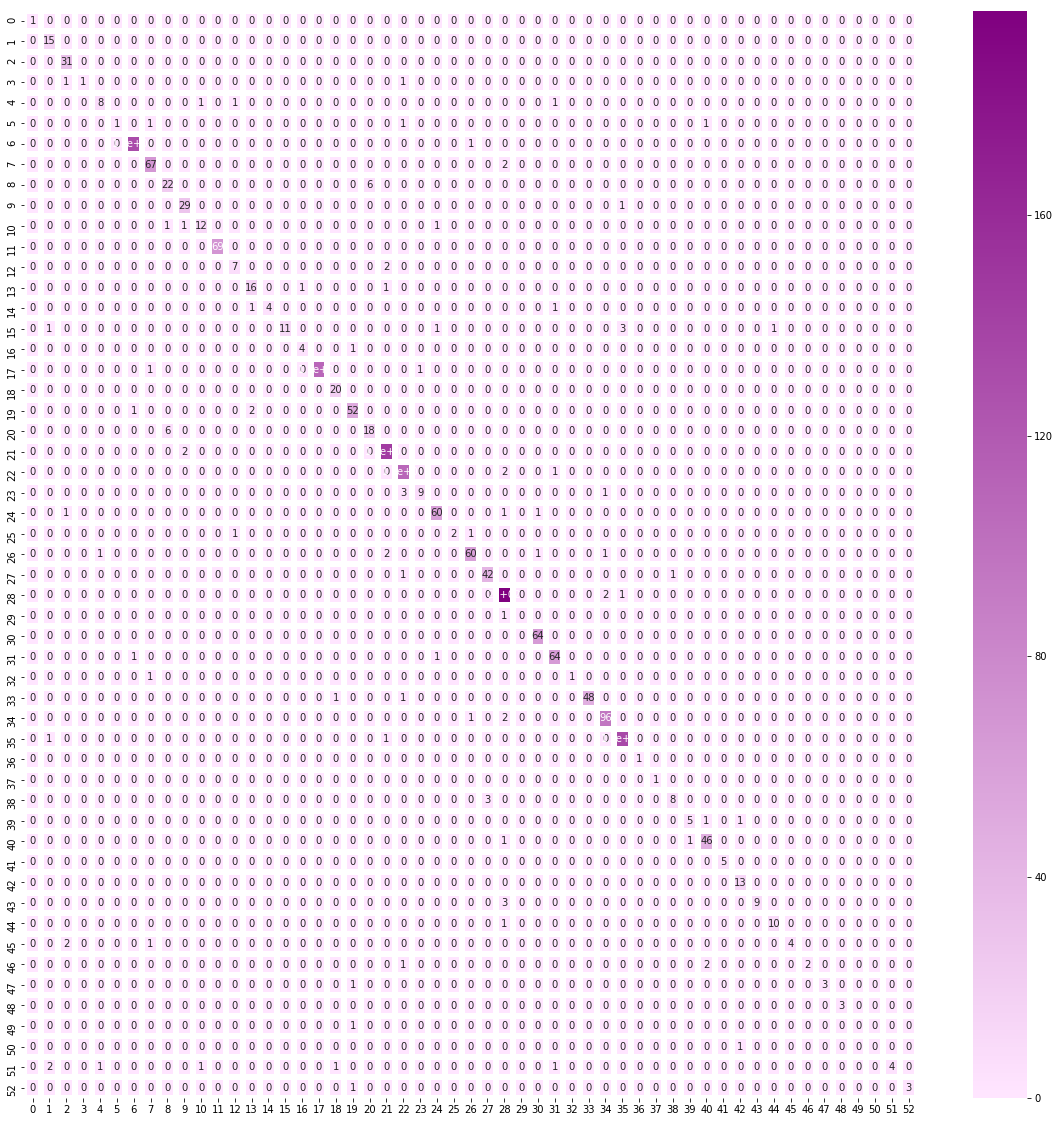

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = base_model.predict_classes(x_train)
y_original = np.argmax(y_train, axis=1)

cm = confusion_matrix(y_original, y_pred)
print('confusion matrix for {} features (base):'.format(cm.shape))
print(cm)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm, cmap=sns.light_palette('purple', n_colors=500, as_cmap=True), annot=True, linewidths = 5, ax=ax)

# DOT CLASS

In [18]:
y_train_dot = np_utils.to_categorical(dot_class)

In [19]:
dot_model = Sequential()

dot_model.add(Conv2D(16,(3,3),input_shape = (img_shape[0],img_shape[1],1),activation = 'relu'))
dot_model.add(Conv2D(16,(3,3),activation = 'relu'))
dot_model.add(MaxPooling2D())
dot_model.add(Conv2D(32,(3,3),activation = 'relu'))
dot_model.add(Conv2D(32,(3,3),activation = 'relu'))
dot_model.add(MaxPooling2D())
dot_model.add(Conv2D(64,(3,3),activation = 'relu'))
dot_model.add(Conv2D(64,(3,3),activation = 'relu'))
dot_model.add(MaxPooling2D())
dot_model.add(Flatten())
dot_model.add(Dense(64,activation = 'sigmoid'))
dot_model.add(Dropout(0.5))
dot_model.add(Dense(len(set(dot_class)),activation = 'softmax'))

dot_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

dot_model.fit(x_train,y_train_dot,epochs=10,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 565 samples
Epoch 1/10
1318/1318 [==============================] - 16s 12ms/step - loss: 0.4424 - categorical_accuracy: 0.8771 - val_loss: 0.2397 - val_categorical_accuracy: 0.9434
Epoch 2/10
1318/1318 [==============================] - 16s 12ms/step - loss: 0.3356 - categorical_accuracy: 0.9196 - val_loss: 0.2353 - val_categorical_accuracy: 0.9434
Epoch 3/10
1318/1318 [==============================] - 15s 11ms/step - loss: 0.3405 - categorical_accuracy: 0.9211 - val_loss: 0.2354 - val_categorical_accuracy: 0.9434
Epoch 4/10
1318/1318 [==============================] - 16s 12ms/step - loss: 0.3276 - categorical_accuracy: 0.9211 - val_loss: 0.2355 - val_categorical_accuracy: 0.9434
Epoch 5/10
1318/1318 [==============================] - 14s 11ms/step - loss: 0.3494 - categorical_accuracy: 0.9211 - val_loss: 0.2358 - val_categorical_accuracy: 0.9434
Epoch 6/10
1318/1318 [==============================] - 16s 12ms/step - loss: 0.3470 - categorical_accu

In [20]:
new_adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
dot_model.compile(optimizer=new_adam,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
dot_model.fit(x_train,y_train_dot,epochs=5,batch_size=64,validation_split=0.3)

Train on 1318 samples, validate on 565 samples
Epoch 1/5
1318/1318 [==============================] - 16s 12ms/step - loss: 0.3322 - categorical_accuracy: 0.9211 - val_loss: 0.2367 - val_categorical_accuracy: 0.9434
Epoch 2/5
1318/1318 [==============================] - 15s 12ms/step - loss: 0.3346 - categorical_accuracy: 0.9211 - val_loss: 0.2370 - val_categorical_accuracy: 0.9434
Epoch 3/5
1318/1318 [==============================] - 18s 13ms/step - loss: 0.3337 - categorical_accuracy: 0.9211 - val_loss: 0.2371 - val_categorical_accuracy: 0.9434
Epoch 4/5
1318/1318 [==============================] - 14s 11ms/step - loss: 0.3473 - categorical_accuracy: 0.9211 - val_loss: 0.2382 - val_categorical_accuracy: 0.9434
Epoch 5/5
1318/1318 [==============================] - 16s 12ms/step - loss: 0.3335 - categorical_accuracy: 0.9211 - val_loss: 0.2372 - val_categorical_accuracy: 0.9434


### confusion matrix:

1883/1883 [==============================] - 7s 4ms/step
confusion matrix for (3, 3) features (dot):
[[1747    0    0]
 [ 117    0    0]
 [  19    0    0]]


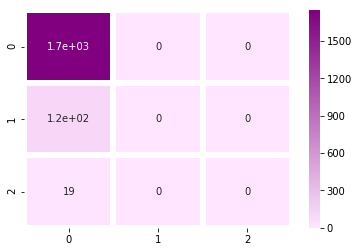

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = dot_model.predict_classes(x_train)
y_original = np.argmax(y_train_dot, axis=1)

cm = confusion_matrix(y_original, y_pred)
print('confusion matrix for {} features (dot):'.format(cm.shape))
print(cm)

#fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm, cmap=sns.light_palette('purple', n_colors=500, as_cmap=True), annot=True, linewidths = 5)

# MATRA CLASS

In [22]:
le_matra = LabelEncoder()
le_matra.fit(matra_class)
y_labeled_matra = le_matra.transform(matra_class)
y_train_matra = np_utils.to_categorical(y_labeled_matra)

print(y_train_matra.shape)

(1883, 16)


In [23]:
matra_model = Sequential()

matra_model.add(Conv2D(16,(3,3),input_shape = (img_shape[0],img_shape[1],1),activation = 'relu'))
matra_model.add(Conv2D(16,(3,3),activation = 'relu'))
matra_model.add(MaxPooling2D())
matra_model.add(Conv2D(32,(3,3),activation = 'relu'))
matra_model.add(Conv2D(32,(3,3),activation = 'relu'))
matra_model.add(MaxPooling2D())
matra_model.add(Conv2D(64,(3,3),activation = 'relu'))
matra_model.add(Conv2D(64,(3,3),activation = 'relu'))
matra_model.add(MaxPooling2D())
matra_model.add(MaxPooling2D())
matra_model.add(Dropout(0.5))
matra_model.add(Flatten())
matra_model.add(Dense(128,activation = 'sigmoid'))
matra_model.add(Dropout(0.25))
matra_model.add(Dense(len(set(matra_class)),activation = 'softmax'))

matra_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['categorical_accuracy'])

matra_model.fit(x_train,y_train_matra,epochs=35,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 565 samples
Epoch 1/35
1318/1318 [==============================] - 16s 12ms/step - loss: 0.1779 - categorical_accuracy: 0.4469 - val_loss: 0.1635 - val_categorical_accuracy: 0.4690
Epoch 2/35
1318/1318 [==============================] - 15s 11ms/step - loss: 0.1537 - categorical_accuracy: 0.4894 - val_loss: 0.1284 - val_categorical_accuracy: 0.5522
Epoch 3/35
1318/1318 [==============================] - 18s 13ms/step - loss: 0.1251 - categorical_accuracy: 0.5903 - val_loss: 0.1182 - val_categorical_accuracy: 0.6230
Epoch 4/35
1318/1318 [==============================] - 17s 13ms/step - loss: 0.1109 - categorical_accuracy: 0.6533 - val_loss: 0.0901 - val_categorical_accuracy: 0.7292
Epoch 5/35
1318/1318 [==============================] - 16s 12ms/step - loss: 0.0928 - categorical_accuracy: 0.7033 - val_loss: 0.0763 - val_categorical_accuracy: 0.7681
Epoch 6/35
1318/1318 [==============================] - 17s 13ms/step - loss: 0.0818 - categorical_accu

In [28]:
new_adam = keras.optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
matra_model.compile(optimizer=new_adam,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
matra_model.fit(x_train,y_train_matra,epochs=20,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 565 samples
Epoch 1/15
1318/1318 [==============================] - 12s 9ms/step - loss: 0.1608 - categorical_accuracy: 0.9545 - val_loss: 0.3796 - val_categorical_accuracy: 0.9168
Epoch 2/15
1318/1318 [==============================] - 14s 11ms/step - loss: 0.1682 - categorical_accuracy: 0.9431 - val_loss: 0.3748 - val_categorical_accuracy: 0.9186
Epoch 3/15
1318/1318 [==============================] - 13s 10ms/step - loss: 0.1570 - categorical_accuracy: 0.9484 - val_loss: 0.3781 - val_categorical_accuracy: 0.9186
Epoch 4/15
1318/1318 [==============================] - 14s 10ms/step - loss: 0.1580 - categorical_accuracy: 0.9530 - val_loss: 0.3848 - val_categorical_accuracy: 0.9168
Epoch 5/15
1318/1318 [==============================] - 15s 11ms/step - loss: 0.1593 - categorical_accuracy: 0.9575 - val_loss: 0.3815 - val_categorical_accuracy: 0.9168
Epoch 6/15
1318/1318 [==============================] - 16s 12ms/step - loss: 0.1722 - categorical_accur

### confusion matrix

1883/1883 [==============================] - 6s 3ms/step
confusion matrix for (16, 16) features (matra):
[[892   0   4   2   0   3   2   0   0   0   0   1   0   0   0   0]
 [  0   0   7   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   0 284   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 179   0   0   0   0   0   1   0   0   0   0   0   0]
 [  1   0   2   1 137   0   0   0   0   0   1   0   0   0   0   0]
 [  3   0   0   0   0  39   0   0   0   0   0   0   0   0   0   0]
 [ 11   0   0   0   1   0  16   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   1   0   0   0   0  81   0   0   0   0   0   0   0]
 [  0   0   0   4   0   0   0   0   1  78   0   3   0   0   0   0]
 [  0   0   0   0   6   0   0   0   3   0  46   1   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   4   1  53   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   

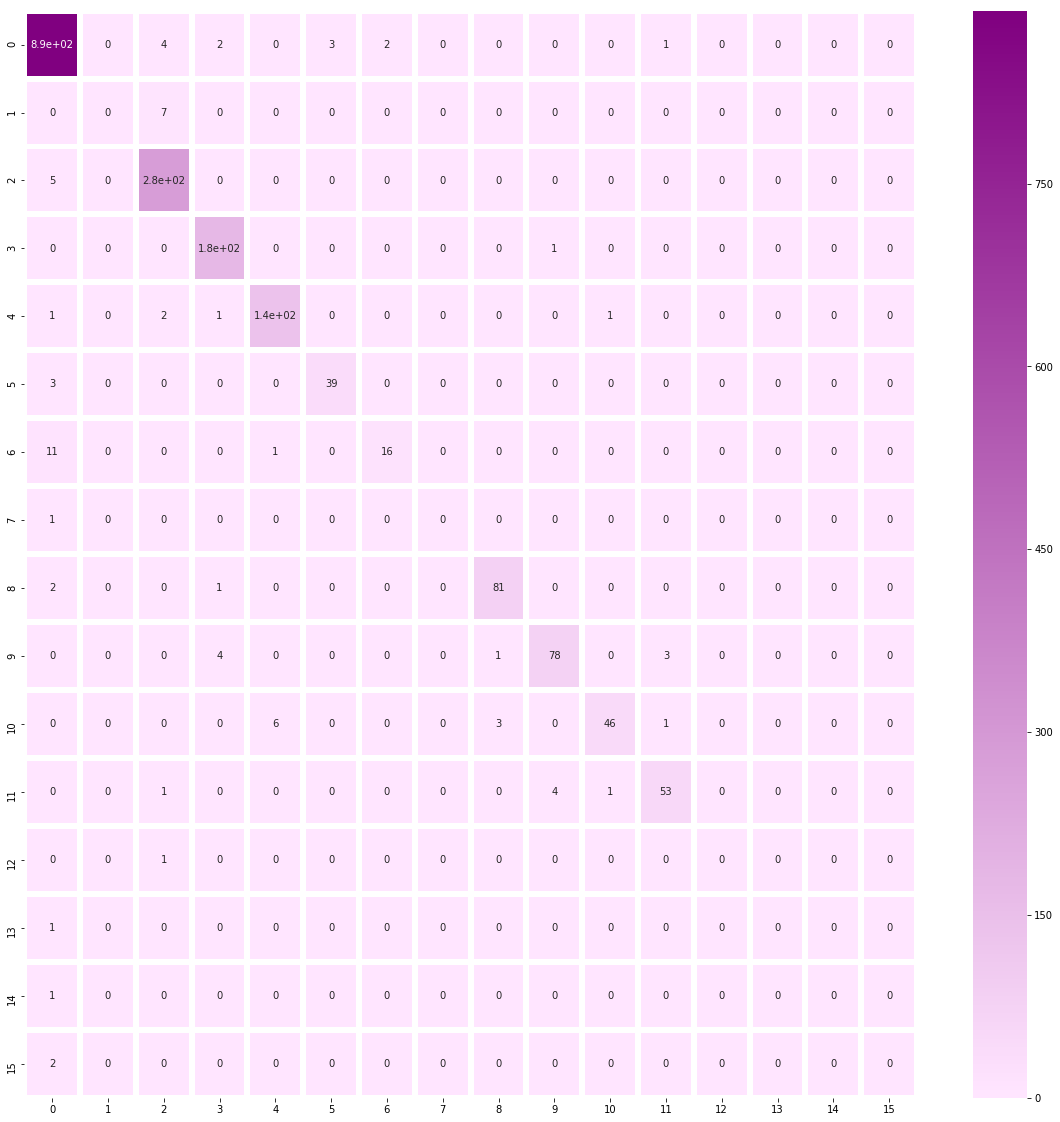

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = matra_model.predict_classes(x_train)
y_original = np.argmax(y_train_matra, axis=1)

cm = confusion_matrix(y_original, y_pred)
print('confusion matrix for {} features (matra):'.format(cm.shape))
print(cm)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm, cmap=sns.light_palette('purple', n_colors=500, as_cmap=True), annot=True, linewidths = 5, ax=ax)

# Dumping Models to Disk

In [26]:
dot_model.save('models/dot_model3k.model')
matra_model.save('models/matra_model3k.model')
base_model.save('models/base_model3k.model')

In [27]:
from keras.models import load_model

dot_model2 = load_model('models/dot_model3k.model')
matra_model2 = load_model('models/matra_model3k.model')
base_model2 = load_model('models/base_model3k.model')



# Half Characters